# Introduction


# Neural style transfer

### Convolutional Neural Network:

Convolutional Neural Networks (CNNs) are a category of Neural Network that have proven very effective in areas such as image recognition and classification. CNNs have been successful in computer vision related problems like identifying faces, objects and traffic signs apart from powering vision in robots and self driving cars.

CNN is shown to be able to well replicate and optimize these key steps in a unified framework and learn hierarchical representations directly from raw images. If we take a convolutional neural network that has already been trained to recognize objects within images then that network will have developed some internal independent representations of the content and style contained within a given image.

In 2014, the winner of the ImageNet challenge was a network created by Visual Geometry Group (VGG) at Oxford University, as a basis for trying to extract content and style representations from images, naming it after them.

The VGG net where shallow layers learns low level features and as we go deeper into the network these convolutional layers are able to represent much larger scale features and thus have a higher-level representation of the image content.

Neural style transfer can be implemented using any pre-trained convnet. Here we will use the VGG19 and VGG16 networks. VGG19 is a simple variant of the VGG16 network, with three more convolutional layers.

Using multiple convolution layers with smaller convolution kernels instead of a larger convolution layer with convolution kernels can reduce parameters on the one hand, and the author believes that it is equivalent to more non-linear mapping, which increases the Fit expression ability.

For the VGG16 network, every step they applied kernals for 2–3 time and then applied a max pooling layer. In our case, we want to account for features across the entire image so we get rid of the maxpool which throws away information and replace those layers for ones that compute the Average Pooling instead. Each time the number of kernals are doubled from the previous layer meaning that each time we trying to extract more and more features. At the end the of the network three fully connected layers are used to limit the relu activation function grow. Dropout is also implemented for reduce overfitting of model.

 ![VGG16](/ImagenesNotebook/vgg16-architecture.png)

Regarding the VGG19 network, it has 16 convolutions with ReLUs between them and five maxpooling layers which we will also substitute for the Average Pooling. The number of filter maps of the convolutions start at 64 and grow until 512. After the convolutions, there is a linear classifier made-up three fully-connected (fc) layers with dropout (SHK * 14) between them, the first two have 4096 features while the last one has 1000. The last fc layer is connected to a softmax which maps each value to the probabilities of belonging to each of the 1000 classes of the ImageNet competition. 

 ![VGG19](/ImagenesNotebook/vgg19-architecture.png)

### Style Transfer

Style Transfer is a technique of modifying one image in style of another image. We are implementing Gatys style transfer which was originally released in 2015 by Gatys et al. The neural style transfer algorithm has undergone many refinements and spawned many variations. Neural style transfer consists in applying the "style" of a reference image to a target image, while conserving the "content" of the target image:

Style refers to the textures, colors, and visual patterns in an image while the "content" is the higher-level macrostructure of the image. 

The key point behind style transfer is same idea that is core to all deep learning algorithms: we define a loss function to specify what we want to achieve, and we minimize this loss. We want to achieve: conserve the "content" of the original image, while adopting the "style" of the reference image. The theoretical loss function would be the following:

We can construct images whose feature maps at a chosen convolution layer match the corresponding feature maps of a given content image. We expect the two images to contain the same content — but not necessarily the same texture and style.

#### Loss

##### The content loss

Given a chosen content layer l, the content loss is defined as the Mean Squared Error between the feature map F of our content image C and the feature map P of our generated image Y.

When this content-loss is minimized, it means that the mixed-image has feature activation in the given layers that are very similar to the activation of the content-image. Depending on which layers we select, this should transfer the contours from the content-image to the mixed-image.

As you already know, *activations from earlier layers in a network contain local information about the image*, while *activations from higher layers contain increasingly global and abstract information*. Therefore we expect the "content" of an image, which is more global and more abstract, to be captured by the representations of a top layer of a convnet.

##### The style loss

Now we want to measure which features in the style-layers activate simultaneously for the style-image, and then copy this activation-pattern to the mixed-image.

One way of doing this, is to calculate the Gram-matrix(a matrix comprising of correlated features) for the tensors output by the style-layers. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer. This inner product can be understood as representing a map of the correlations between the features of a layer. These feature correlations capture the statistics of the patterns of a particular spatial scale, which empirically corresponds to the appearance of the textures found at this scale. If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.

Hence the style loss aims at preserving similar internal correlations within the activations of different layers, across the style reference image and the generated image. In turn, this guarantees that the textures found at different spatial scales will look similar across the style reference image and the generated image. The loss function for style is quite similar to out content loss, except that we calculate the Mean Squared Error for the Gram-matrices instead of the raw tensor-outputs from the layers.

### TL:DR

In short, being the content image the one we wish to modify and the style reference image the one we obtain the style from, we can use a pre-trained convnet to define a loss that will:

* Preserve content by maintaining similar high-level layer activations between the target content image and the generated image. The convnet should "see" both the target image and the generated image as "containing the same things".
* Preserve style by maintaining similar correlations within activations for both low-level layers and high-level layers. Indeed, feature correlations capture textures: the generated and the style reference image should share the same textures at different spatial scales.

In [1]:
from __future__ import print_function, division
from builtins import range, input

from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import preprocess_input

from keras.preprocessing import image
from skimage.transform import resize
import tensorflow as tf

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from scipy.optimize import fmin_l_bfgs_b
from keras.preprocessing.image import save_img

import time
import imageio
from PIL import Image

tf.compat.v1.disable_eager_execution()

## Functions

In [2]:
def load_img_and_preprocess(path, shape=None):
    img = image.load_img(path, target_size=shape)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [3]:
def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [4]:
def VGG16_AvgPool(shape):
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
    i = vgg.input
    x = i
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
        # replace it with average pooling
            x = AveragePooling2D()(x)
        else:
            x = layer(x)

    return Model(i, x)

In [5]:
def VGG19_AvgPool(shape):
    vgg = VGG19(input_shape=shape, weights='imagenet', include_top=False)
    i = vgg.input
    x = i
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
        # replace it with average pooling
            x = AveragePooling2D()(x)
        else:
            x = layer(x)

    return Model(i, x)

In [6]:
def content_loss(base, combination):
    return K.mean(K.square(combination - base))

In [7]:
def gram_matrix(img):
    # input is (H, W, C) (C = # feature maps)
    # we need to convert it to (C, H*W)
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))

    # now, calculate the gram matrix
    # gram = XX^T / N
    G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
    return G

In [8]:
def style_loss(style, combination):
    return K.mean(K.square(gram_matrix(style) - gram_matrix(combination)))


def minimize(fn, epochs, batch_shape, vgg):
    import time
    path = 'C:/Users/USER/Desktop/Comillas/Análisis datos no estructurados/IMAGEN/Neural-Transfer/'
    results_folder = 'Results/'
    results_prefix = 'style_transfer_result'
    t0 = datetime.now()
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        start_time = time.time()
        x, l, _ = fmin_l_bfgs_b(
          func=fn,
          x0=x,
          maxfun=20
        )
        x = np.clip(x, -127, 127)
        if vgg == 'VGG16':
            imagen = x.copy()
            imagen = imagen.reshape(*batch_shape)
            imagen = unpreprocess(imagen)
            fname = path + results_folder + results_prefix + vgg + '_at_iteration_%d.png' % i
            imageio.imwrite(fname, imagen[0])
        else:
            imagen = x.copy()
            imagen = imagen.reshape(*batch_shape)
            imagen = unpreprocess(imagen)
            fname = path + results_folder + results_prefix + vgg + '_at_iteration_%d.png' % i
            imageio.imwrite(fname, imagen[0])
        
        print("iter=%s, loss=%s" % (i, l))
        losses.append(l)
        end_time = time.time()
        print('Iteration %d completed in %ds' % (i, end_time - start_time))

    print("duration:", datetime.now() - t0)
    plt.plot(losses)
    plt.show()

    newimg = x.reshape(*batch_shape)
    final_img = unpreprocess(newimg)
    return final_img[0]

In [9]:
def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

## Code

In [10]:
# folder names with content and style images
style_path = 'StyleImages'
content_path = 'ContentImages'

In [11]:
# to get multiple files
style_files = glob(style_path + '/*.jp*g')
content_files = glob(content_path + '/*.jp*g')

In [12]:
c_img = np.random.choice(content_files)
s_img = np.random.choice(style_files)

In [13]:
content_img = load_img_and_preprocess(c_img)

In [14]:
h, w = content_img.shape[1:3]
style_img = load_img_and_preprocess(s_img, (h, w))

# batch_shape and shape of the image
batch_shape = content_img.shape
shape = content_img.shape[1:]

In [15]:
# we call the function VGG16_AvgPool which initializes the model
vgg = VGG16_AvgPool(shape)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 683, 910, 3), dtype=float32)


In [16]:
# we call the function VGG19_AvgPool which initializes the model
vgg19 = VGG19_AvgPool(shape)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 683, 910, 3), dtype=float32)


In [17]:
vgg.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           multiple             0           ['input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 683, 910, 64  1792        ['input_1[1][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 683, 910, 64  36928       ['block1_conv1[1][0]']           
                                )                                                                 
                                                                                              

In [18]:
vgg19.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           multiple             0           ['input_2[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 683, 910, 64  1792        ['input_2[1][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 683, 910, 64  36928       ['block1_conv1[1][0]']           
                                )                                                                 
                                                                                            

In [19]:
# create the content model
content_model = Model(vgg.input, vgg.layers[13].get_output_at(1))
content_target = K.variable(content_model.predict(content_img))

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 683, 910, 3), dtype=float32)


In [20]:
# create the content model for vgg19
content_model_vgg19 = Model(vgg19.input, vgg19.layers[16].get_output_at(0))
content_target_vgg19 = K.variable(content_model_vgg19.predict(content_img))

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 683, 910, 3), dtype=float32)


In [21]:
# create the style model
# multiple outputs
symbolic_conv_outputs = [
  layer.get_output_at(1) for layer in vgg.layers \
  if layer.name.endswith('conv1')
]

# unified model that outputs multiple layers' outputs
style_model = Model(vgg.input, symbolic_conv_outputs)

# calculate the targets that are the output at each layer
style_layers_outputs = [K.variable(y) for y in style_model.predict(style_img)]

# style losses weight
style_weights = [0.2,0.4,0.3,0.5,0.2]

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_1:0", shape=(None, 683, 910, 3), dtype=float32)


In [22]:
# create the style model
# multiple outputs
symbolic_conv_outputs_vgg19 = [
  layer.get_output_at(1) for layer in vgg19.layers \
  if layer.name.endswith('conv1')
]

# unified model that outputs multiple layers' outputs
style_model_vgg19 = Model(vgg19.input, symbolic_conv_outputs_vgg19)

# calculate the targets that are the output at each layer
style_layers_outputs_vgg19 = [K.variable(y) for y in style_model_vgg19.predict(style_img)]

# style losses weights
style_weights = [0.2,0.4,0.3,0.5,0.2]

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 683, 910, 3), dtype=float32)


In [23]:
content_weight = 1

In [24]:
# total loss which is the sum of content + style loss
loss = content_weight * content_loss(content_model.output, content_target)

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs, style_layers_outputs):
    loss += w * style_loss(symbolic[0], actual[0])

# create the gradients and loss + grads function
grads = K.gradients(loss, vgg.input)

get_loss_and_grads = K.function(inputs=[vgg.input], outputs=[loss] + grads)

In [25]:
# create the total loss which is the sum of content + style loss for vgg19
loss_vgg19 = K.mean(K.square(content_model_vgg19.output - content_target_vgg19))

for w, symbolic, actual in zip(style_weights, symbolic_conv_outputs_vgg19, style_layers_outputs_vgg19):
    loss_vgg19 += w * style_loss(symbolic[0], actual[0])

# create the gradients and loss + grads function
grads_vgg19 = K.gradients(loss_vgg19, vgg19.input)

get_loss_and_grads_vgg19 = K.function(inputs=[vgg19.input], outputs=[loss_vgg19] + grads_vgg19)

In [26]:
def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

In [27]:
def get_loss_and_grads_wrapper_vgg19(x_vec):
    l, g = get_loss_and_grads_vgg19([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

iter=0, loss=5564.37353515625
Iteration 0 completed in 71s
iter=1, loss=924.5989990234375
Iteration 1 completed in 65s
iter=2, loss=402.274169921875
Iteration 2 completed in 64s
iter=3, loss=292.3500671386719
Iteration 3 completed in 64s
iter=4, loss=241.588134765625
Iteration 4 completed in 64s
iter=5, loss=214.97140502929688
Iteration 5 completed in 64s
iter=6, loss=196.15843200683594
Iteration 6 completed in 64s
iter=7, loss=182.69261169433594
Iteration 7 completed in 64s
iter=8, loss=170.40399169921875
Iteration 8 completed in 64s
iter=9, loss=160.8563995361328
Iteration 9 completed in 63s
duration: 0:10:54.178375


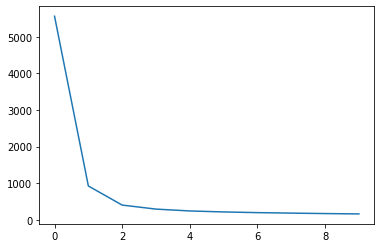

In [28]:
VGG16 = 'VGG16'
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape, VGG16)

iter=0, loss=2955.01708984375
Iteration 0 completed in 71s
iter=1, loss=1155.303955078125
Iteration 1 completed in 72s
iter=2, loss=748.515625
Iteration 2 completed in 72s
iter=3, loss=596.3060913085938
Iteration 3 completed in 73s
iter=4, loss=528.2870483398438
Iteration 4 completed in 75s
iter=5, loss=486.26123046875
Iteration 5 completed in 72s
iter=6, loss=458.8323059082031
Iteration 6 completed in 71s
iter=7, loss=438.0899353027344
Iteration 7 completed in 71s
iter=8, loss=422.4071960449219
Iteration 8 completed in 71s
iter=9, loss=410.00640869140625
Iteration 9 completed in 72s
duration: 0:12:05.500897


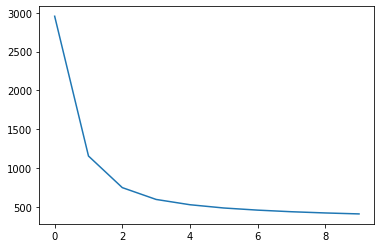

In [29]:
VGG19 = 'VGG19'
final_img_vgg19 = minimize(get_loss_and_grads_wrapper_vgg19, 10, batch_shape, VGG19)

# Plot the images

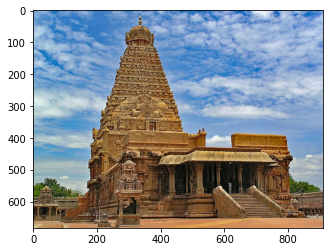

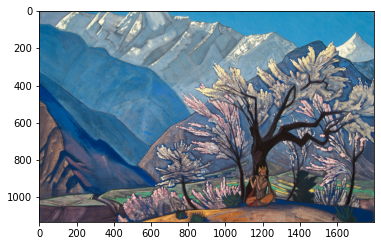

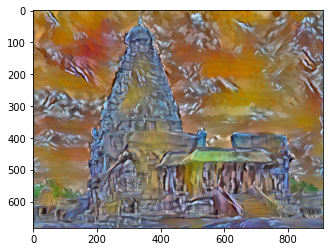

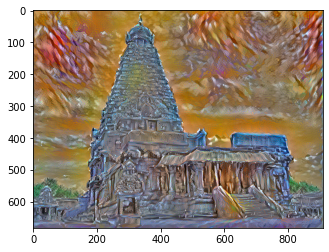

In [30]:
# Content image
plt.imshow(image.load_img(c_img))
plt.figure()

# Style image
plt.imshow(image.load_img(s_img))
plt.figure()

# Generated image VGG16
plt.imshow(np.flip(scale_img(final_img), axis = 1))
plt.show()

# Generated image VGG16
plt.imshow(np.flip(scale_img(final_img_vgg19), axis = 1))
plt.show()